# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [21]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


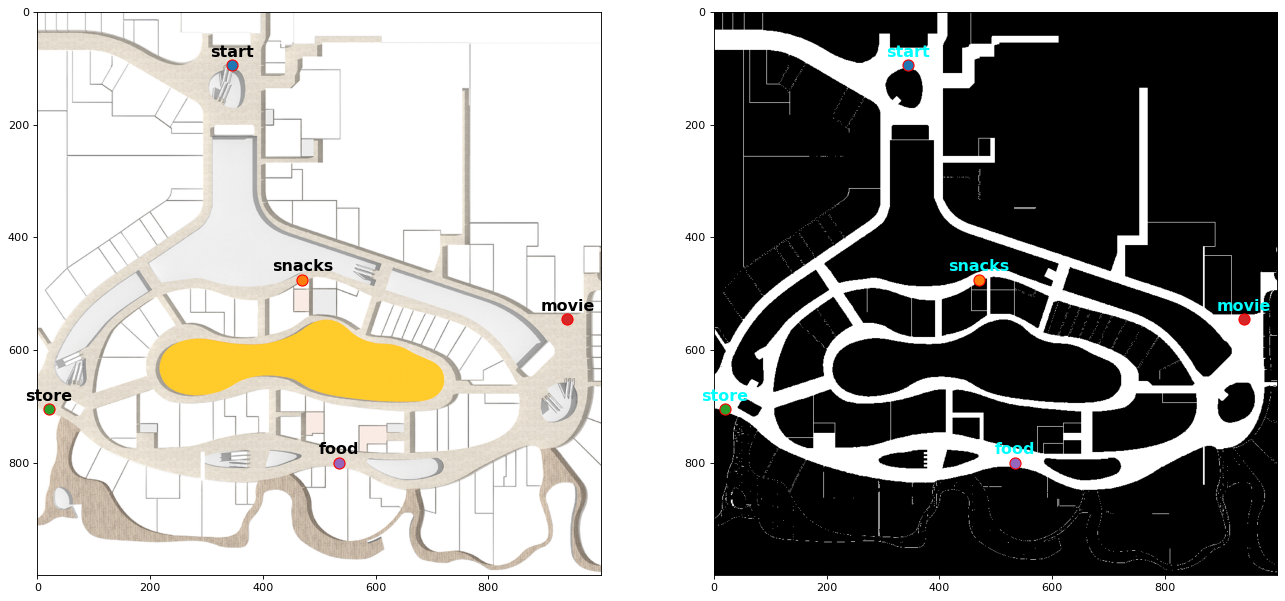

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [22]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1
## 1.1 Implement A*

Travelled Distance: 178.20199999999886 m
Run Time: 2.1690428256988525 seconds
Path_len: 785


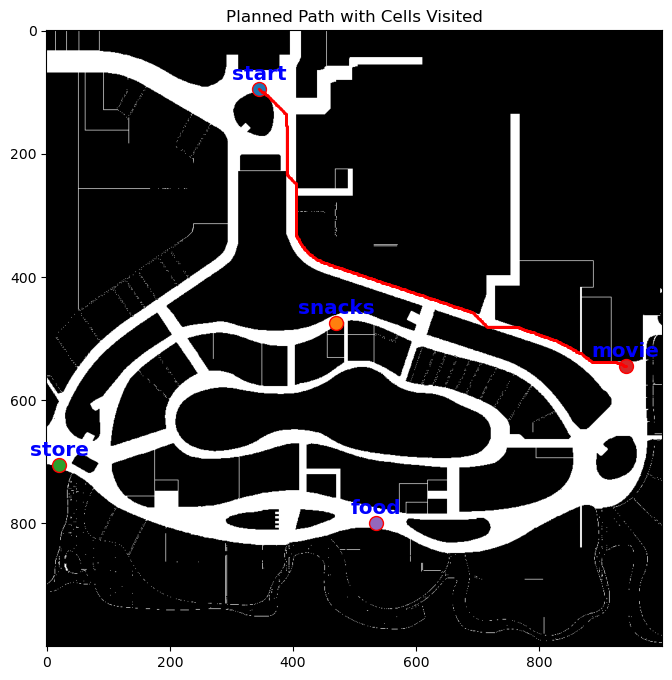

In [23]:
import time
def heuristic_function(start, goal):
    return np.sqrt((start[0] - goal[0]) ** 2 + (start[1] - goal[1]) ** 2) * MAP_RES

def is_valid(neighbor, grid_map):
    return (0 <= neighbor[0] < grid_map.shape[0] and 
            0 <= neighbor[1] < grid_map.shape[1] and 
            grid_map[neighbor[0], neighbor[1]] == 255)

def get_cost(dx, dy):
    return 0.282 if dx != 0 and dy != 0 else 0.2

def reconstruct_path(came_from, current):
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        total_path.append(current)
    return total_path

def calculate_distance(path):
    total_distance = 0
    for i in range(1, len(path)):
        dx = path[i][0] - path[i-1][0]
        dy = path[i][1] - path[i-1][1]
        total_distance += get_cost(dx, dy)
    return total_distance

def a_star(start, goal, grid_map):
    open_set = {start}
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic_function(start, goal)}

    while open_set:
        current = min(open_set, key=lambda x: f_score[x])
        if current == goal:
            return reconstruct_path(came_from, goal)

        open_set.remove(current)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue

                neighbor = (current[0] + dx, current[1] + dy)
                if not is_valid(neighbor, grid_map):
                    continue

                cost = get_cost(dx, dy)
                tentative_g_score = g_score[current] + cost
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic_function(neighbor, goal)
                    if neighbor not in open_set:
                        open_set.add(neighbor)

    return None

# Finding path from start to store
start_time = time.time()
path = a_star(tuple(locations['start']), tuple(locations['movie']), grid_map)
total_distance = calculate_distance(path)
end_time = time.time()
print("Travelled Distance:", total_distance, "m")
print("Run Time:", end_time - start_time, "seconds")
# print("Path_len:", len(path))


# Visualize the planned path and cells visited
plt.figure(figsize=(8, 8))
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='blue')
if path:
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, marker='o', color='red', markersize=1, linestyle='-')
plt.title('Planned Path with Cells Visited')
plt.show()

## 1.2 Implement Dijkstra

Travelled Distance: 178.20199999999835 m
Run Time: 5.7455830574035645 seconds
Path_len: 785


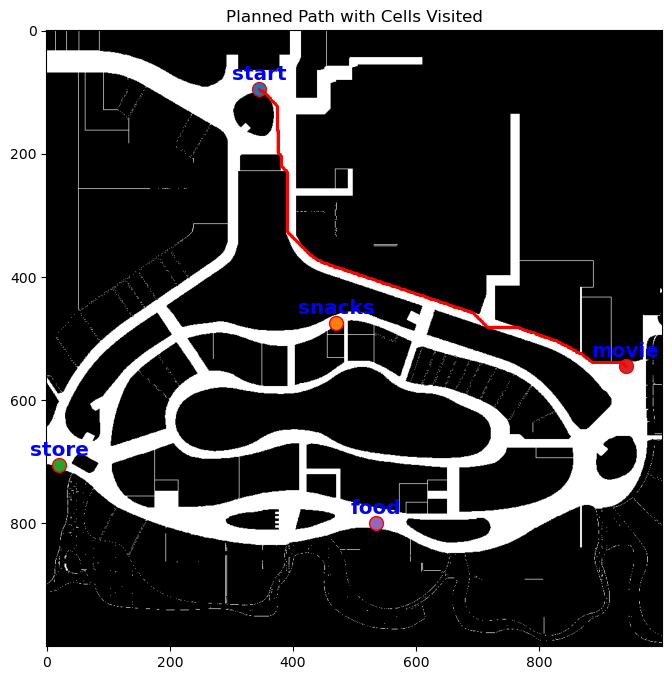

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time


def dijkstra(start, goal, grid_map):
    open_set = {start}
    came_from = {}
    g_score = {start: 0}

    while open_set:
        current = min(open_set, key=lambda x: g_score[x])
        if current == goal:
            return reconstruct_path(came_from, current)

        open_set.remove(current)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue

                neighbor = (current[0] + dx, current[1] + dy)
                if not is_valid(neighbor, grid_map):
                    continue

                cost = get_cost(dx, dy)
                tentative_g_score = g_score[current] + cost
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    if neighbor not in open_set:
                        open_set.add(neighbor)

    return None

start_time = time.time()
path = dijkstra(tuple(locations['start']), tuple(locations['movie']), grid_map)
total_distance = calculate_distance(path)
end_time = time.time()
print("Travelled Distance:", total_distance, "m")
print("Run Time:", end_time - start_time, "seconds")
# print("Path_len:", len(path))

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='blue')
if path:
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, marker='o', color='red', markersize=1, linestyle='-')
plt.title('Planned Path with Cells Visited')
plt.show()


## 1.3 Implement Greedy Best First Search

Travelled Distance: 183.69799999999867 m
Run Time: 0.18589997291564941 seconds
Path_len: 801


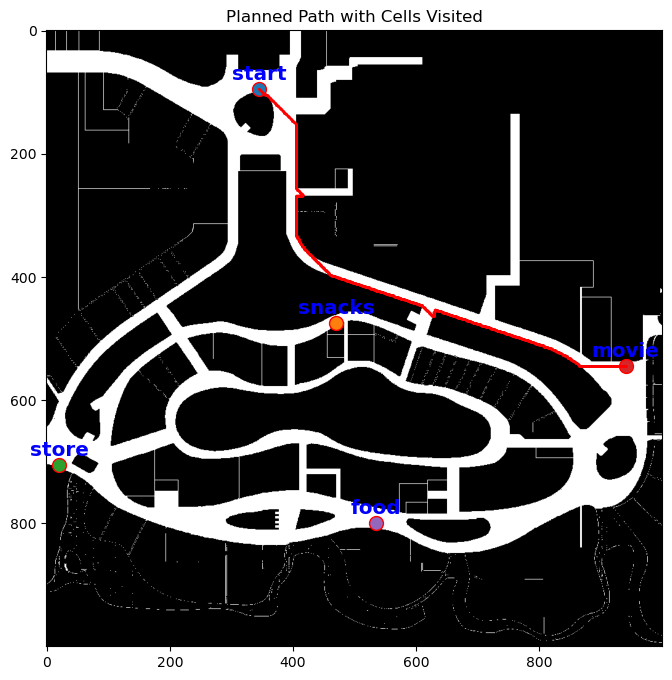

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time


def greedy_best_first_search(start, goal, grid_map):
    open_set = {start}
    came_from = {}
    f_score = {start: heuristic_function(start, goal)}

    while open_set:
        current = min(open_set, key=lambda x: f_score[x])
        if current == goal:
            return reconstruct_path(came_from, current)

        open_set.remove(current)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue

                neighbor = (current[0] + dx, current[1] + dy)
                if not is_valid(neighbor, grid_map):
                    continue

                if neighbor not in f_score:
                    came_from[neighbor] = current
                    f_score[neighbor] = heuristic_function(neighbor, goal)
                    if neighbor not in open_set:
                        open_set.add(neighbor)

    return None

start_time = time.time()
path = greedy_best_first_search(tuple(locations['start']), tuple(locations['movie']), grid_map)
end_time = time.time()

total_distance = calculate_distance(path)
print("Travelled Distance:", total_distance, "m")
print("Run Time:", end_time - start_time, "seconds")
# print("Path_len:", len(path))

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='blue')
if path:
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, marker='o', color='red', markersize=1, linestyle='-')
plt.title('Planned Path with Cells Visited')
plt.show()

## Task 2